In [1]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
import os
os.chdir('/Users/wjl/Documents/GitHub/CreditRiskModelling/')
from scripts.synthetic_data_creation import SyntheticDataCreator
from scripts.feature_engineering import FeatureEngineering
from scripts.model_training import ModelTraining

seed = 23

# Step 1: Synthetic Data Creation

In [2]:
sdc = SyntheticDataCreator()
df = sdc.generate_synthetic_data()


Data saved to /data/synthetic_credit_data.csv


# Step 2: Feature Engineering

In [3]:
# 2.1: Initilizing FeatureEngineering
reference_date = sdc.reference_date
fe = FeatureEngineering(df, reference_date=reference_date)

# 2.2: Derive Features
derived_df = fe.derive_features()

# 2.3: Train/Test Data Split - Optional
train_idx,test_idx=fe.train_test_split()


Feature Derivation Complete.

Features derived are:
Index(['drv_profit_pm_avg_t12m', 'drv_income_pm_avg_t3m',
       'drv_tran_vol_pm_avg_t3m', 'drv_tran_cnt_pm_avg_t3m',
       'drv_profit_margin_rate', 'drv_asset_liability_rate',
       'drv_loan_util_rate', 'drv_inflow_outflow_rate_t3m',
       'drv_addr_cons_flag', 'drv_industry_cons_flag', 'drv_mon_since_apply',
       'drv_mon_since_last_late', 'drv_mon_till_mature',
       'drv_tran_vol_std_t12m', 'drv_inflow_std_t6m',
       'drv_trans_vol_prop_t1t3', 'drv_credit_inquiry_prop_t3t12'],
      dtype='object')
Dropping date columns...

Features dropped are:
['loan_start_date', 'loan_maturity_date', 'loan_last_late_date']


### Logistic Regression
!!! take 1 min to run

[INFO] filtering variables ...
Variable filtering on 10000 rows and 52 columns in 00:00:30 
32 variables are removed
IV of remaining features are:
                   variable  info_value
1        loan_interest_rate    0.966847
6              tran_cnt_t3m    0.392466
2   drv_tran_cnt_pm_avg_t3m    0.392466
11             credit_score    0.357922
10            business_size    0.324428
16  loan_utilization_amount    0.226418
15    drv_income_pm_avg_t3m    0.199759
14             tran_cnt_t1m    0.173402
8              tran_vol_t1m    0.133454
7           tran_inflow_t3m    0.125741
17         tran_outflow_t3m    0.112561
18               fin_profit    0.081762
12   drv_profit_pm_avg_t12m    0.081762
0               loan_amount    0.058679
13              fin_revenue    0.055315
9              tran_vol_t3m    0.037936
3   drv_tran_vol_pm_avg_t3m    0.037936
5        plat_login_cnt_t1m    0.014945
4             business_time    0.010627
[INFO] creating woe binning ...


/Users/wjl/Library/Python/3.9/lib/python/site-packages/scorecardpy/woebin.py:320: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  init_bin = dtm.groupby('bin', group_keys=False)['y'].agg([n0, n1])\
/Users/wjl/Library/Python/3.9/lib/python/site-packages/scorecardpy/woebin.py:320: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  init_bin = dtm.groupby('bin', group_keys=False)['y'].agg([n0, n1])\
/Users/wjl/Library/Python/3.9/lib/python/site-packages/scorecardpy/woebin.py:320: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to r

Plot binning results...


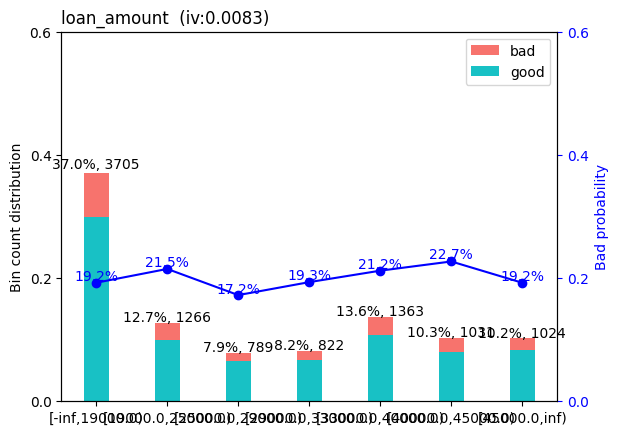

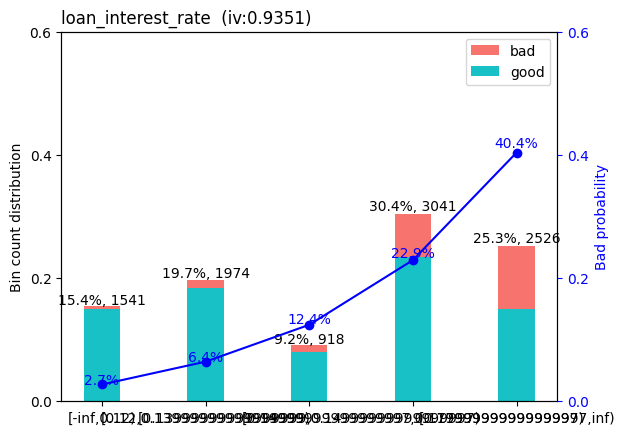

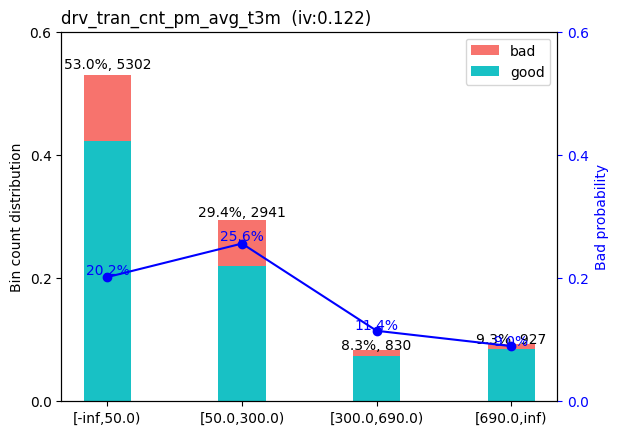

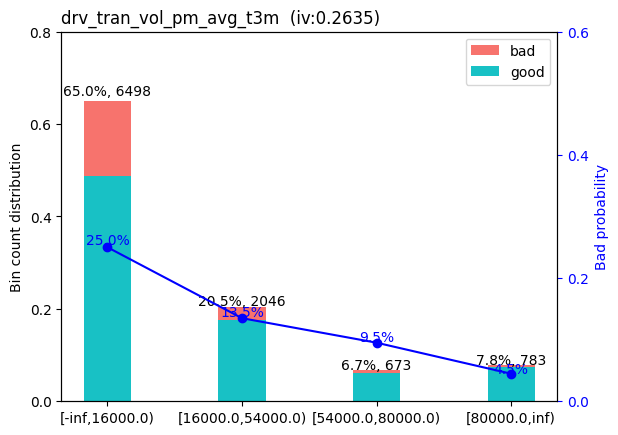

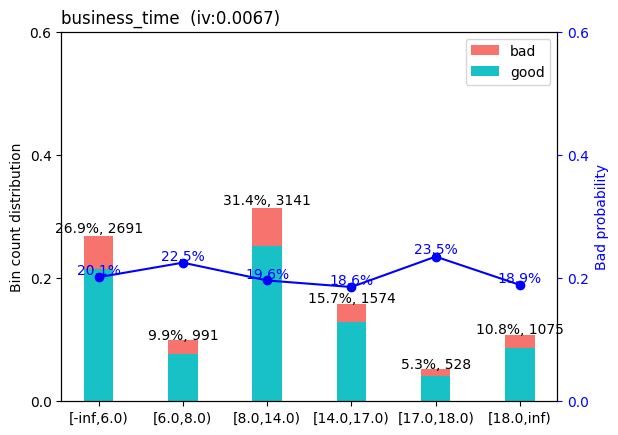

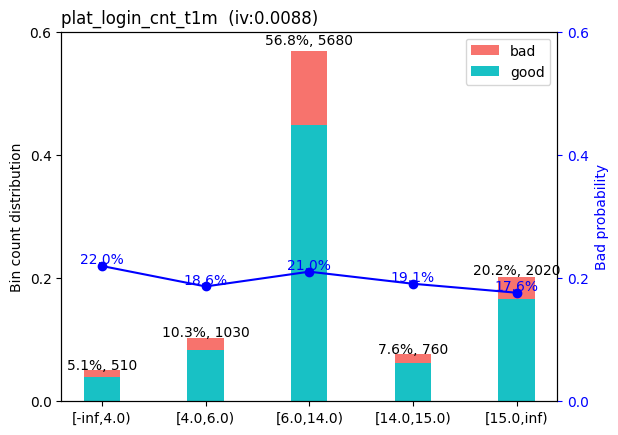

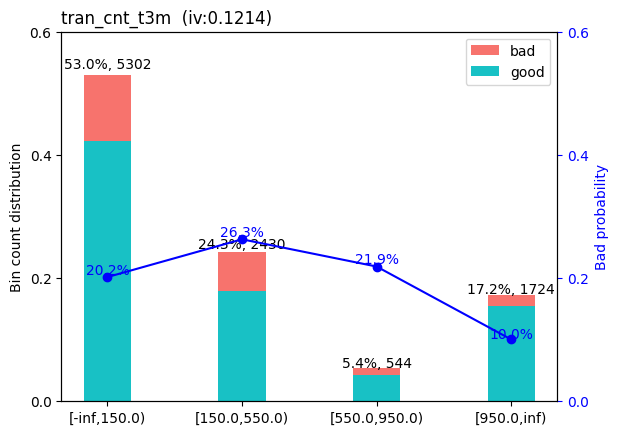

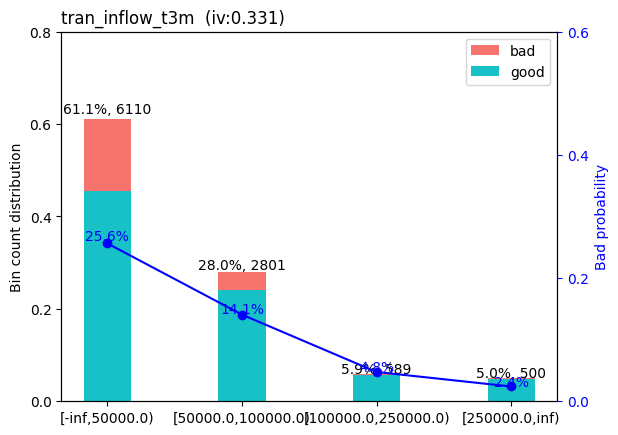

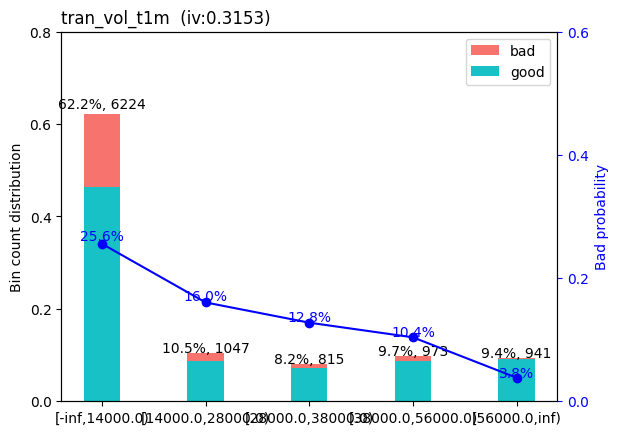

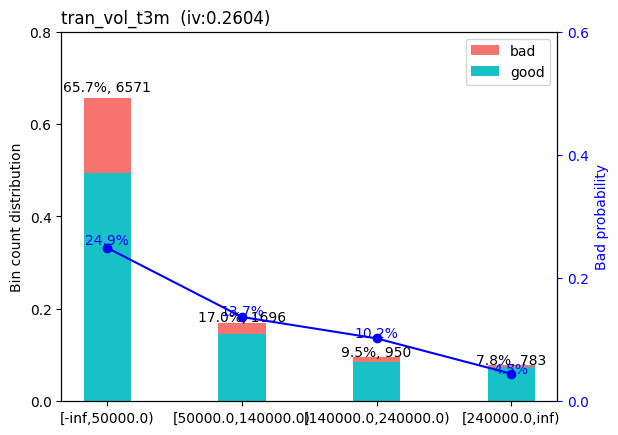

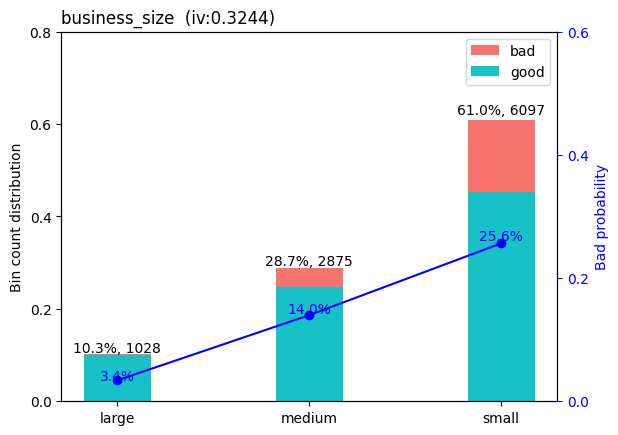

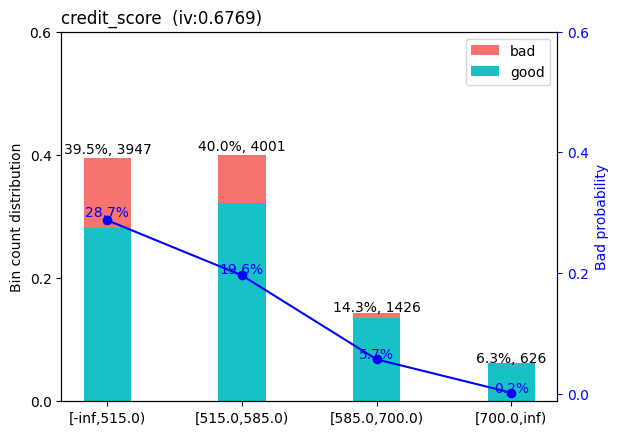

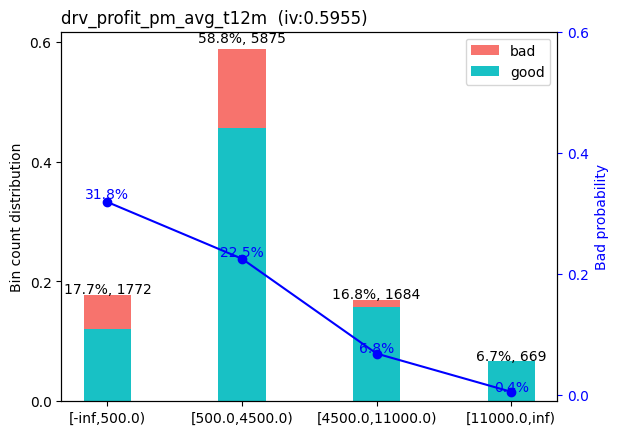

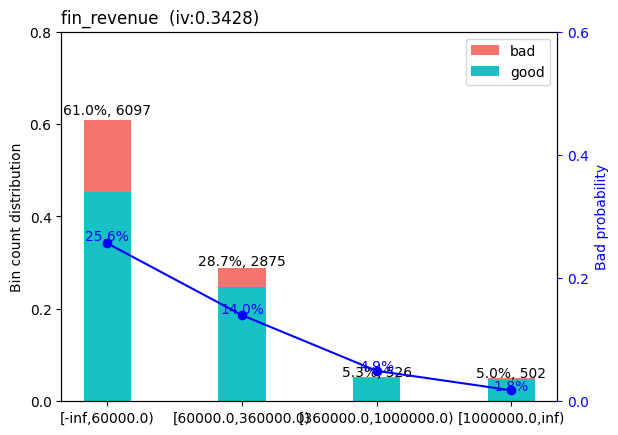

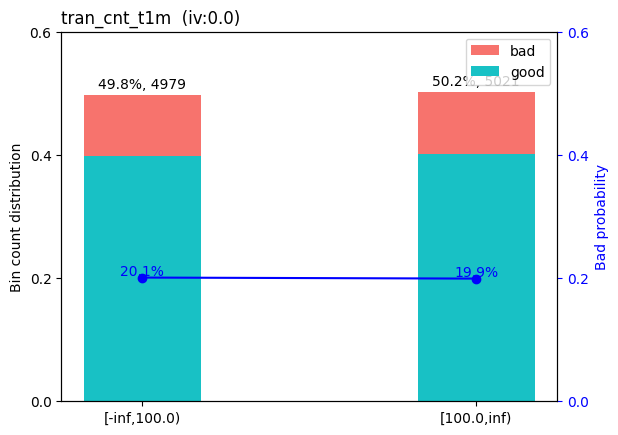

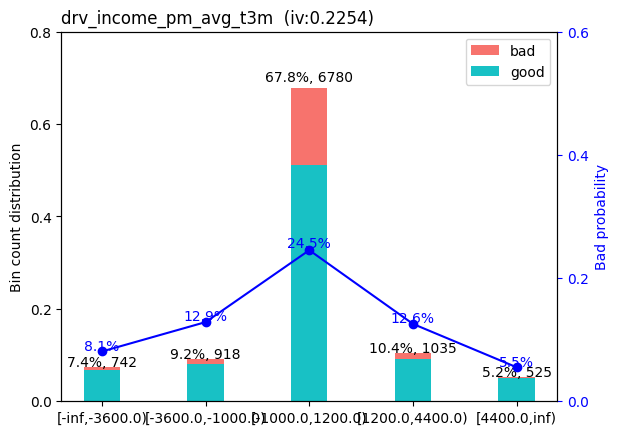

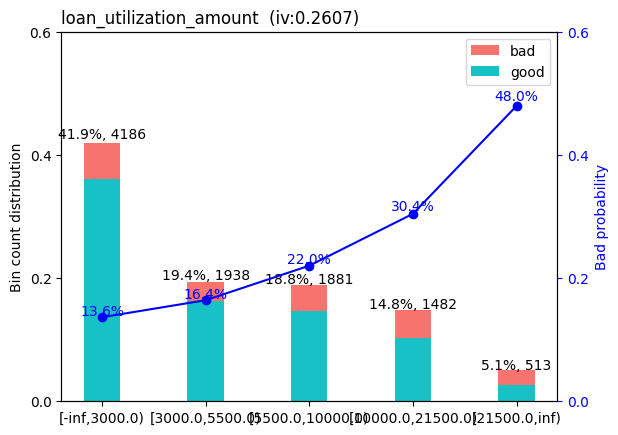

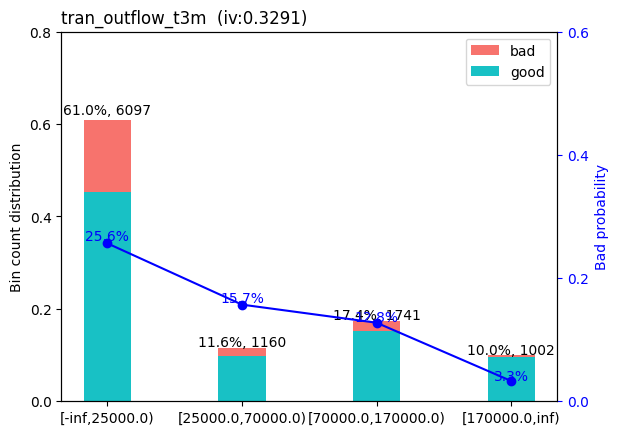

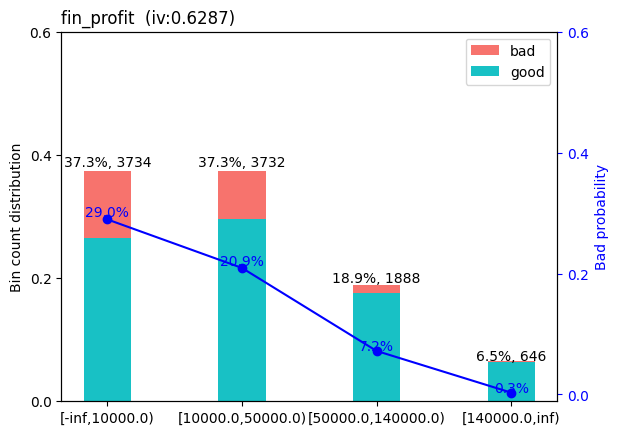

[INFO] creating woe binning ...


/Users/wjl/Library/Python/3.9/lib/python/site-packages/scorecardpy/woebin.py:320: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  init_bin = dtm.groupby('bin', group_keys=False)['y'].agg([n0, n1])\
/Users/wjl/Library/Python/3.9/lib/python/site-packages/scorecardpy/woebin.py:410: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  total_iv_all_brks = pd.melt(
/Users/wjl/Library/Python/3.9/lib/python/site-packages/scorecardpy/woebin.py:410: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep cur

Plot binning results...


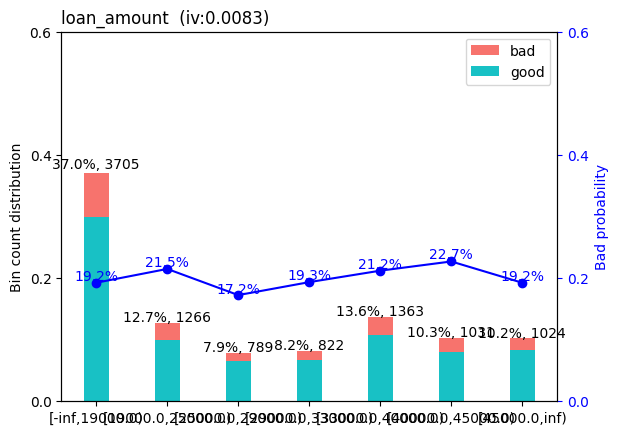

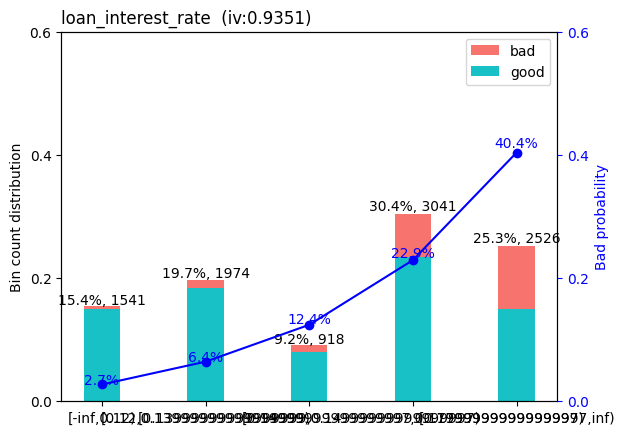

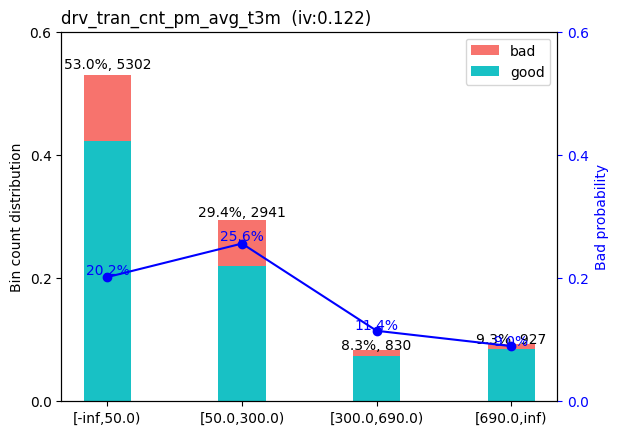

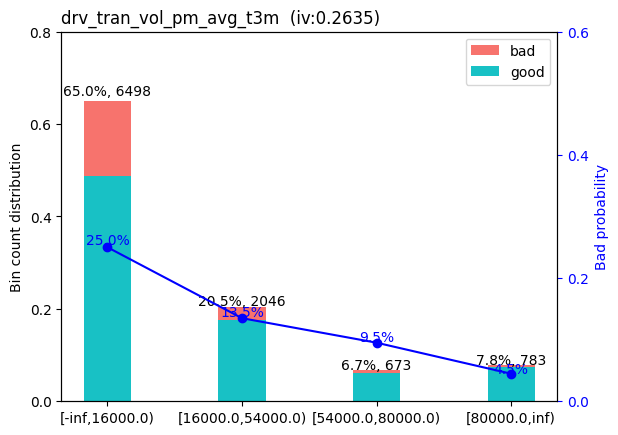

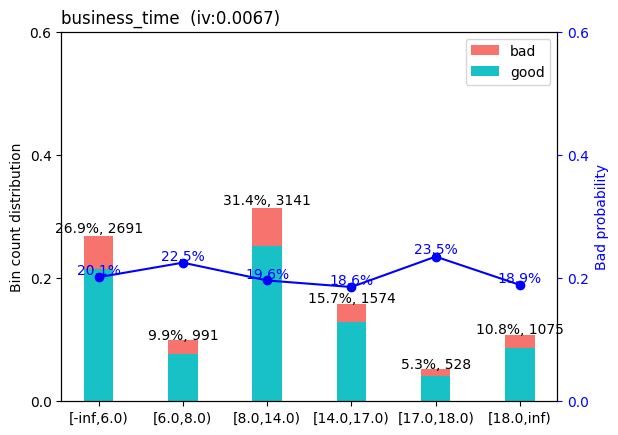

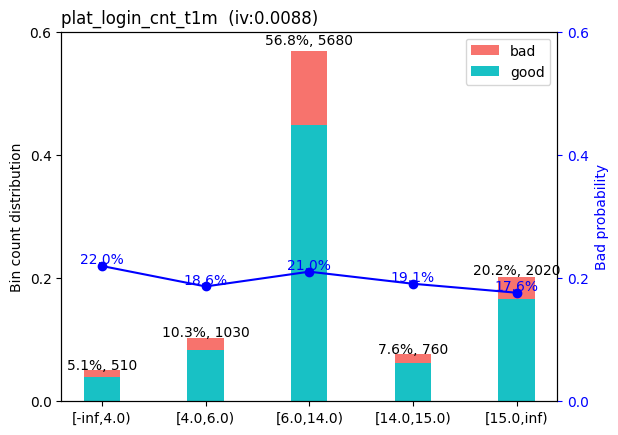

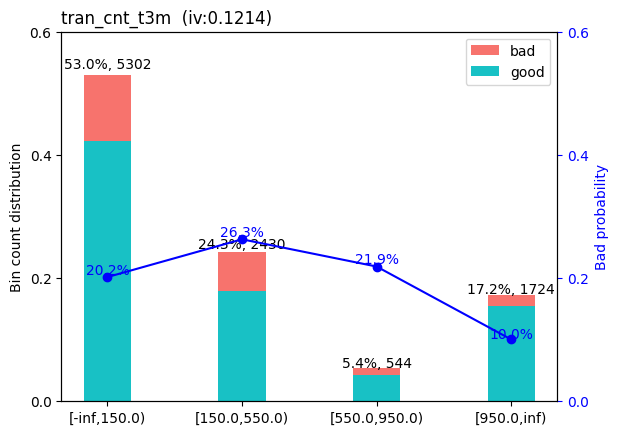

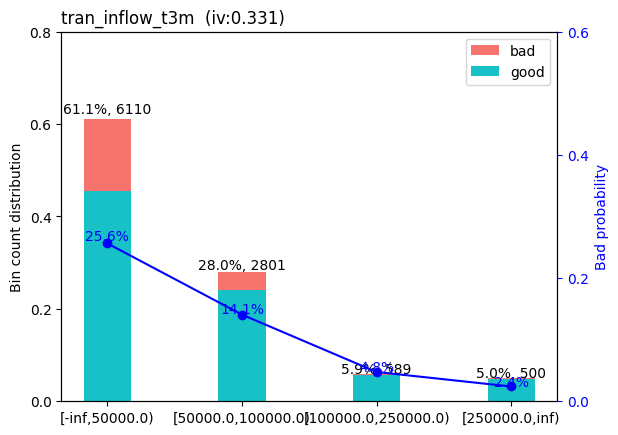

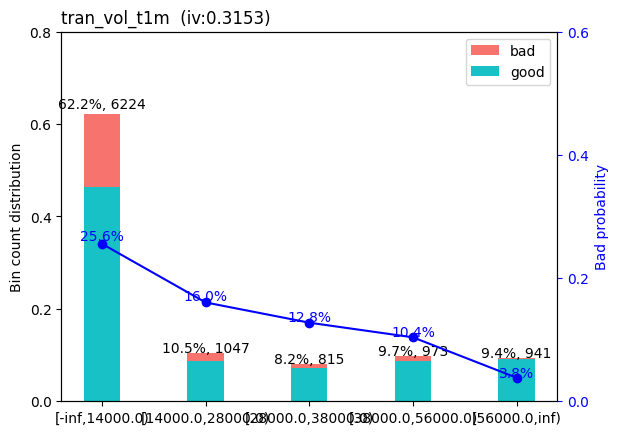

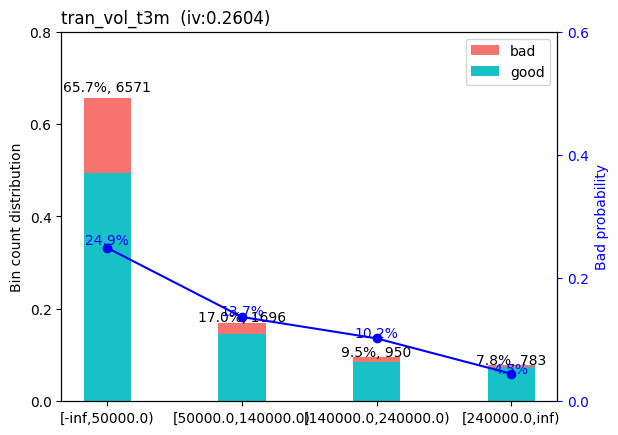

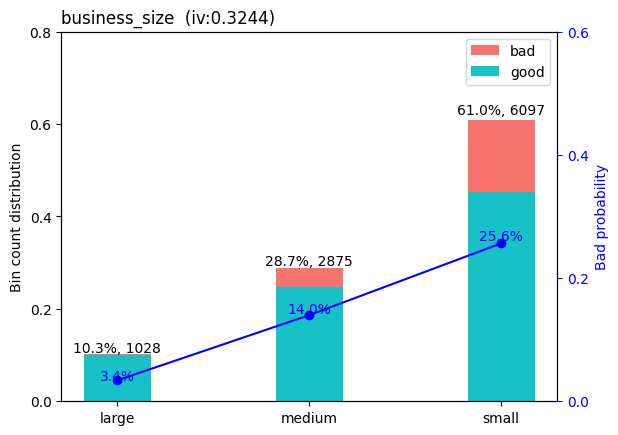

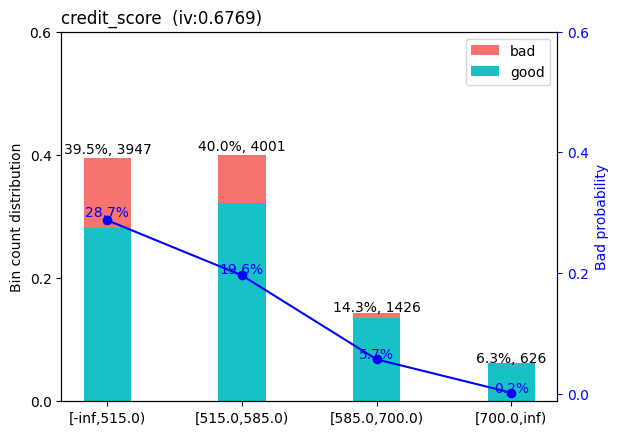

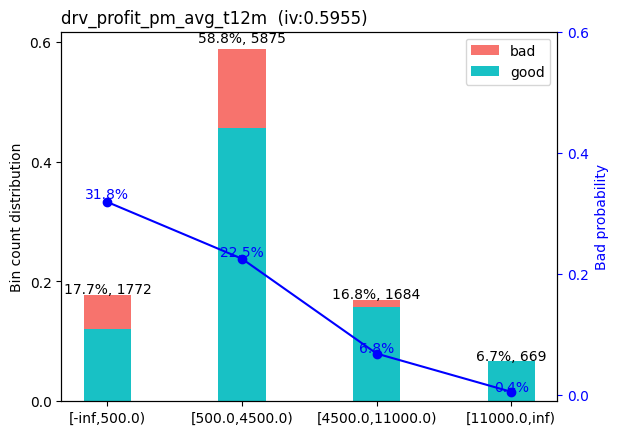

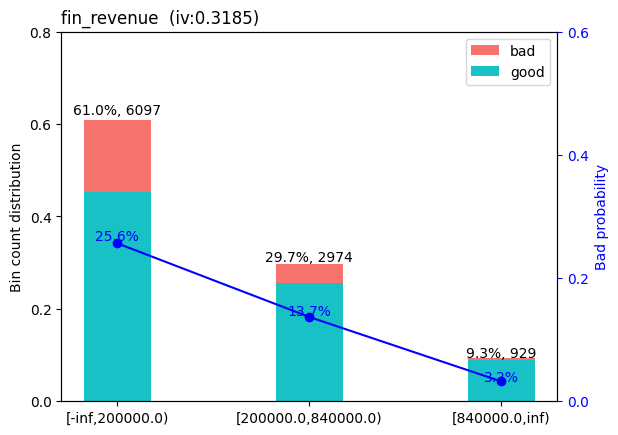

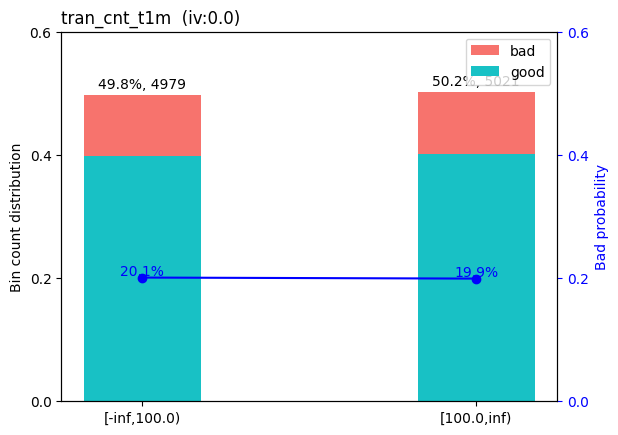

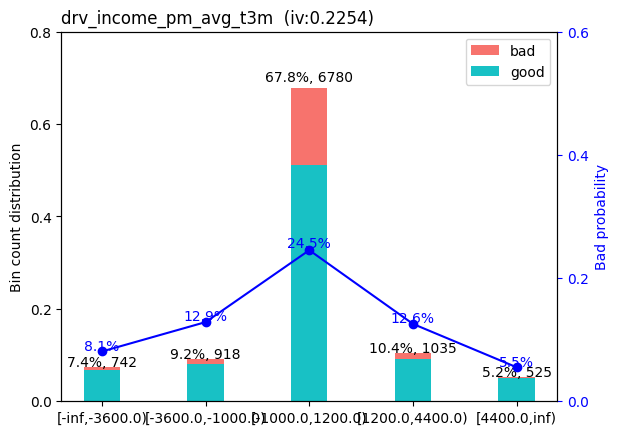

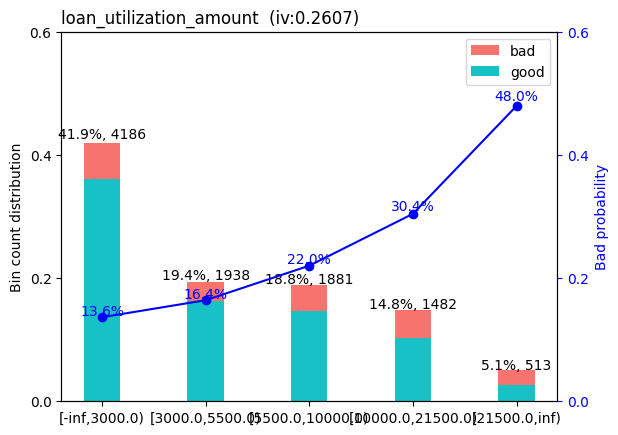

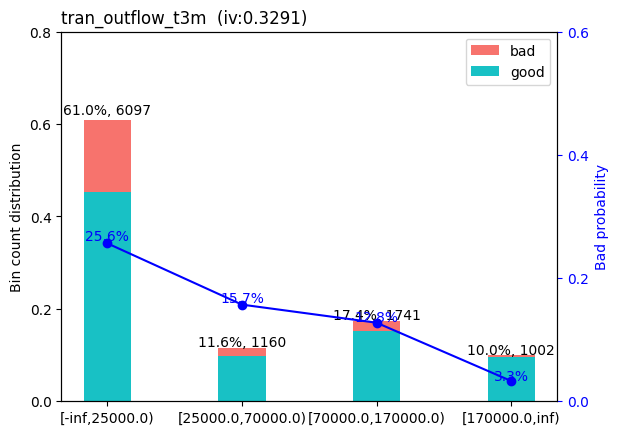

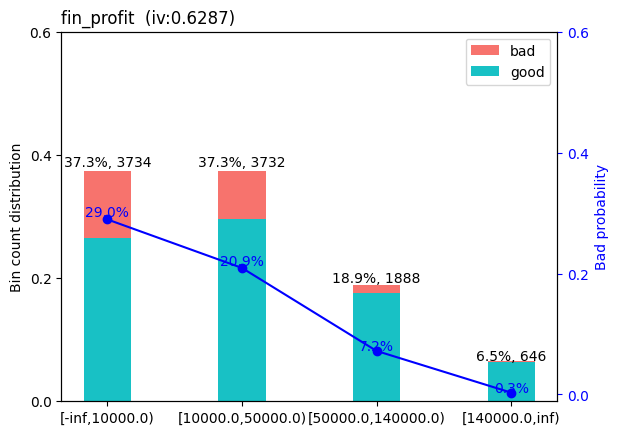

In [4]:
# Step 2.4 Feature Transforming

## Step 2.4.1. Initial Select Features based on IV
selected_features = fe.lr_select_features_iv(var_keep=['plat_login_cnt_t1m','business_time'])

## Step 2.4.2: Transform Features

# WoE Binning
bins = fe.lr_transform_features()

# Adjust WoE Binning - just an example
breaks_adj = {
    'drv_loan_util_rate': [0.4, 0.56],
    'fin_revenue': [200000,840000]
}
bins=fe.lr_transform_features(break_adj=breaks_adj)

In [5]:
# Step 2.5 Select Features - Stepwise Final Selection
result = fe.lr_select_features_stepwise(save_list=['plat_login_cnt_t1m_woe'])

[INFO] converting into woe values ...
Add  loan_interest_rate_woe         with p-value 2.29922e-143
Add  loan_utilization_amount_woe    with p-value 1.67204e-77
Add  fin_profit_woe                 with p-value 3.58508e-62
Add  credit_score_woe               with p-value 3.40228e-05
Add  business_size_woe              with p-value 0.00795832
Add  drv_profit_pm_avg_t12m_woe     with p-value 0.0243704


### XGBoost Classifier
since there are only 50 features, no actual needs to narrow down the the features, 
but we can still try to see if we can get a better result by using features with higher importance

In [6]:
xdf=fe.xgb_transform_features()
fe.xgb_select_features(40)

Feature Importance of remaining features are:
loan_interest_rate                0.140184
drv_loan_util_rate                0.062436
fin_profit                        0.060498
credit_score                      0.057462
business_structure_sole trader    0.025910
loan_utilization_amount           0.023004
business_industry_retail          0.022669
drv_addr_cons_flag_0              0.022507
drv_profit_margin_rate            0.022235
loan_amount                       0.021069
tran_inflow_t3m                   0.020319
business_time                     0.019998
business_location_rural           0.019754
plat_customer_support_cnt_t3m     0.019560
plat_dashboard_cnt_t3m            0.019429
drv_inflow_std_t6m                0.019196
loan_late_repayment_cnt           0.019188
tran_vol_t3m                      0.019166
plat_login_cnt_t1m                0.019056
credit_lines_cnt                  0.019044
drv_asset_liability_rate          0.019037
fin_assets                        0.019020
fin_reve

['business_time',
 'business_review',
 'plat_customer_support_cnt_t3m',
 'plat_dashboard_cnt_t3m',
 'plat_saving_acct_flag',
 'plat_login_cnt_t1m',
 'fin_revenue',
 'fin_profit',
 'fin_assets',
 'fin_liabilities',
 'tran_vol_t1m',
 'tran_vol_t3m',
 'tran_cnt_t3m',
 'tran_inflow_t3m',
 'tran_outflow_t3m',
 'credit_score',
 'credit_lines_cnt',
 'credit_current_amt',
 'credit_inquiry_cnt_t3m',
 'credit_inquiry_cnt_t12m',
 'credit_court_cnt_t12m',
 'loan_amount',
 'loan_late_repayment_cnt',
 'loan_interest_rate',
 'loan_utilization_amount',
 'drv_income_pm_avg_t3m',
 'drv_profit_margin_rate',
 'drv_asset_liability_rate',
 'drv_loan_util_rate',
 'drv_inflow_outflow_rate_t3m',
 'drv_tran_vol_std_t12m',
 'drv_inflow_std_t6m',
 'drv_trans_vol_prop_t1t3',
 'drv_credit_inquiry_prop_t3t12',
 'business_industry_retail',
 'business_structure_partnership',
 'business_structure_sole trader',
 'business_location_rural',
 'business_location_suburban',
 'drv_addr_cons_flag_0',
 'default']

### ANN

In [7]:
adf=fe.ann_transform_features()
fe.ann_select_features(40)

Feature Importance of remaining features are:
loan_interest_rate                0.140184
drv_loan_util_rate                0.062436
fin_profit                        0.060498
credit_score                      0.057462
business_structure_sole trader    0.025910
loan_utilization_amount           0.023004
business_industry_retail          0.022669
drv_addr_cons_flag_0              0.022507
drv_profit_margin_rate            0.022235
loan_amount                       0.021069
tran_inflow_t3m                   0.020319
business_time                     0.019998
business_location_rural           0.019754
plat_customer_support_cnt_t3m     0.019560
plat_dashboard_cnt_t3m            0.019429
drv_inflow_std_t6m                0.019196
loan_late_repayment_cnt           0.019188
tran_vol_t3m                      0.019166
plat_login_cnt_t1m                0.019056
credit_lines_cnt                  0.019044
drv_asset_liability_rate          0.019037
fin_assets                        0.019020
fin_reve

['business_time',
 'business_review',
 'plat_customer_support_cnt_t3m',
 'plat_dashboard_cnt_t3m',
 'plat_saving_acct_flag',
 'plat_login_cnt_t1m',
 'fin_revenue',
 'fin_profit',
 'fin_assets',
 'fin_liabilities',
 'tran_vol_t1m',
 'tran_vol_t3m',
 'tran_cnt_t3m',
 'tran_inflow_t3m',
 'tran_outflow_t3m',
 'credit_score',
 'credit_lines_cnt',
 'credit_current_amt',
 'credit_inquiry_cnt_t3m',
 'credit_inquiry_cnt_t12m',
 'credit_court_cnt_t12m',
 'loan_amount',
 'loan_late_repayment_cnt',
 'loan_interest_rate',
 'loan_utilization_amount',
 'drv_income_pm_avg_t3m',
 'drv_profit_margin_rate',
 'drv_asset_liability_rate',
 'drv_loan_util_rate',
 'drv_inflow_outflow_rate_t3m',
 'drv_tran_vol_std_t12m',
 'drv_inflow_std_t6m',
 'drv_trans_vol_prop_t1t3',
 'drv_credit_inquiry_prop_t3t12',
 'business_industry_retail',
 'business_structure_partnership',
 'business_structure_sole trader',
 'business_location_rural',
 'business_location_suburban',
 'drv_addr_cons_flag_0',
 'default']

# Step 3 Model trainning

In [8]:
mt = ModelTraining(fe)
mt.train_test_split()

Train and test datasets saved to 'data/' directory.


### LR
Logistic Regression (LR) is a simple, interpretable model for binary classification.
##### Key Techniques:
Information Value (IV): Selects features with high predictive power. \
Weight of Evidence (WoE): Transforms categorical features into numerical values. \
Stepwise Selection: Reduces overfitting by selecting the most relevant features.
XGBoost

In [9]:
# Hyperparameter grid for tuning
param_grid_lr = {
    "penalty": ["l1", "l2","elasticnet"],
    "C": [0.5, 0.6,0.7, 0.9, 1.0],
    "solver": ["liblinear", "saga"],
}
mt.train_model(model_type='LR',params=param_grid_lr)

Best parameters for LR: {'C': 0.5, 'penalty': 'l2', 'solver': 'liblinear'}
Cross-Validation Results Top 10:
      C penalty     solver  mean_test_score  std_test_score
2   0.5      l2  liblinear         0.842030        0.007758
3   0.5      l2       saga         0.842026        0.007735
18  0.9      l1  liblinear         0.842002        0.007635
8   0.6      l2  liblinear         0.842000        0.007635
19  0.9      l1       saga         0.841996        0.007638
20  0.9      l2  liblinear         0.841993        0.007669
6   0.6      l1  liblinear         0.841985        0.007683
7   0.6      l1       saga         0.841984        0.007695
25  1.0      l1       saga         0.841984        0.007594
26  1.0      l2  liblinear         0.841983        0.007636
Train AUC: 0.843, Test AUC: 0.844
Train KS: 0.541, Test KS: 0.539
LR model saved to 'models/best_lr_model.pkl'.


LogisticRegression(C=0.5, max_iter=1000, n_jobs=-1, solver='liblinear')

### XGBoost 
XGBoost is a powerful ensemble method for handling complex, non-linear relationships.
##### Key Techniques:
Feature Importance: Selects features based on their contribution to the model.\
!!! Take 1 min to run with below params in tuning

In [10]:
# Hyperparameter grid for tuning
param_grid_xgb = {
    "learning_rate": [0.01, 0.05, 0.1],  # Smaller learning rate for slower learning
    "max_depth": [3, 4, 5],  # Shallower trees to reduce complexity
    "min_child_weight": [1, 3, 5],  # Control leaf node size
    "gamma": [0, 0.1, 0.2]  # Regularization to prevent splits with low gain
    # "subsample": [0.6, 0.8, 1.0],  # Randomly sample rows to reduce overfitting
    # "colsample_bytree": [0.6, 0.8, 1.0],  # Randomly sample columns to reduce overfitting
    # "n_estimators": [100, 200, 300],  # Limit the number of boosting rounds
}
mt.train_model(model_type='XGB',params=param_grid_xgb)

Best parameters for XGB: {'gamma': 0.2, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 5}
Cross-Validation Results Top 10:
    gamma  learning_rate  max_depth  min_child_weight  mean_test_score  \
65    0.2           0.05          3                 5         0.860506   
11    0.0           0.05          3                 5         0.860459   
36    0.1           0.05          3                 1         0.860411   
9     0.0           0.05          3                 1         0.860411   
38    0.1           0.05          3                 5         0.860360   
63    0.2           0.05          3                 1         0.860322   
10    0.0           0.05          3                 3         0.860308   
37    0.1           0.05          3                 3         0.860275   
64    0.2           0.05          3                 3         0.860275   
12    0.0           0.05          4                 1         0.859133   

    std_test_score  
65        0.004963  
11      

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.2, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, random_state=23, ...)

### ANN
Artificial Neural Networks (ANN) can capture intricate patterns in data.
##### Key Techniques:
Feature Scaling: Normalizes features to improve convergence.
Warning !!! take 10+ minutes to train with below features in tuning

In [ ]:
param_grid_ann = {
"hidden_layer_sizes": [(50,), (100,), (100, 50)],  # Deeper architectures can be time consuming
    "activation": ["relu", "tanh"],  # Avoid sigmoid for deeper networks
    "solver": ["adam"],  # Adam optimizer is generally better for most cases
    "alpha": [0.0001, 0.001, 0.01],  # Regularization strength
    "learning_rate_init": [0.001, 0.01],  # Learning rate
    "batch_size": [32, 64, 128],  # Mini-batch size
    "max_iter": [100, 200],  # Increase iterations for convergence
    "n_iter_no_change":[10],  # Stop if no improvement for 10 epochs
    "early_stopping": [True]  # Stop training if validation loss doesn't improve
    }
mt.train_model(model_type='ANN',params=param_grid_ann)


## Step 4 Model Evaluations
##### Key Metrics:
AUC (Area Under Curve): Measures model discrimination ability.\
KS (Kolmogorov-Smirnov): Measures the separation between positive and negative classes.


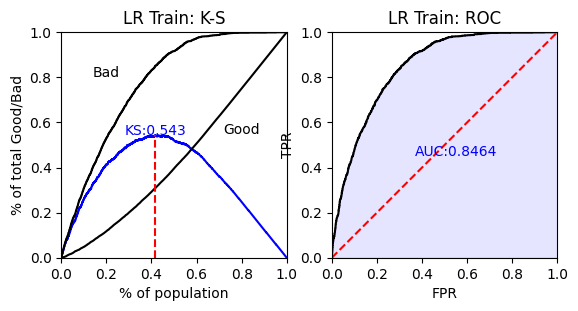

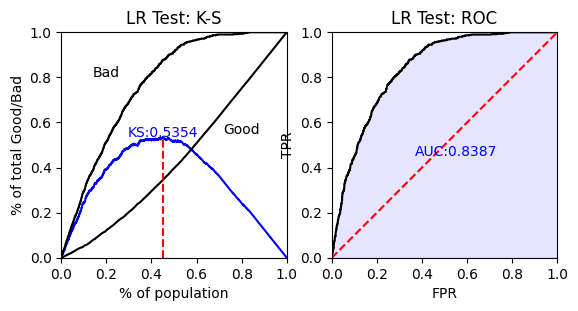

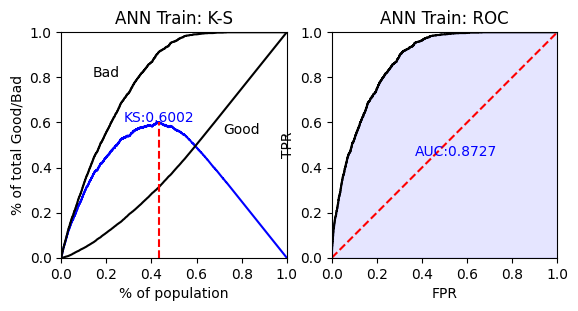

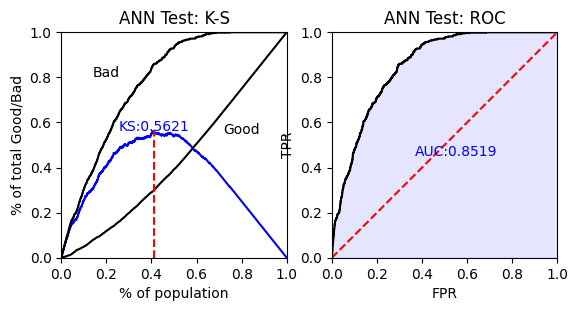

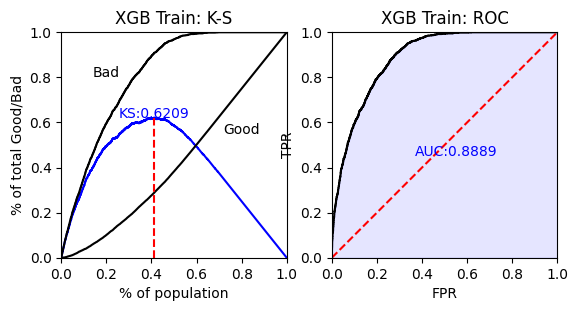

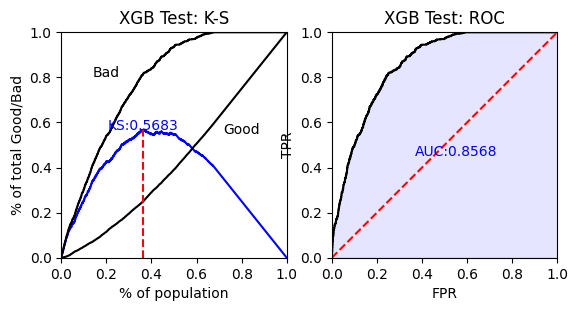

In [ ]:
mt.plot_performance_evaluation(models=["LR","ANN", "XGB"])

In [26]:
mt.plot_feature_importance(models=["LR","ANN", "XGB"])

Feature importance plot saved to 'models/lr_IV Score.png'.
Feature importance plot saved to 'models/ann_Permutation Importance.png'.
Feature importance plot saved to 'models/xgb_Feature Importance.png'.


# Step 5 Future Enhancements
### 1. Real-World Data: 
Replace synthetic data with actual credit data.\
### 2. Model Explainability: 
ANN and XGB can be hard to diretly explain.(currently implictly on feature importance)\
### 3. Model Stability:
The Population Stability Index (PSI) measures the distribution shift between the training data and future data. Use data from 2024-10-01 to 2024-12-31 as validate data to test stability\
PSI < 0.1: Excellent stability.\
0.1 < PSI < 0.2: Acceptable stability.\
PSI > 0.2: Unstable model; requires investigation and adjustment.\
### 4. Deployment: 
Integrate models into a production environment for real-time risk assessment.
### 5. Consider AutoML:
Automated Machine Learning can quickly generate baseline models for comparison with custom-built models, especially for tasks where interpretability is not a primary concern.\ However, in credit risk modeling, interpretability is often critical for regulatory compliance and stakeholder trust.

